In [38]:
import pandas as pd, numpy as np, os, joblib, matplotlib.pyplot as plt, seaborn as sns, json, traceback
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import mutual_info_classif

In [39]:
sns.set(style="whitegrid")
RANDOM_STATE = 42

In [40]:
# === Paths ===
csv_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls"
out_dir = "inx_outputs"
os.makedirs(out_dir, exist_ok=True)

In [41]:
# Make sure xlrd is installed:
# pip install xlrd==1.2.0

## Convert XLS to CSV

xls_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls"
csv_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv"

df = pd.read_excel(xls_path, engine="xlrd")
df.to_csv(csv_path, index=False)
print("Converted successfully:", csv_path)


Converted successfully: ./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv


In [42]:
# === Paths ===
csv_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv"
out_dir = "inx_outputs"
os.makedirs(out_dir, exist_ok=True)

In [43]:
# === 1. Load ===
df = pd.read_csv(csv_path)
print("Loaded:", csv_path, "shape:", df.shape)
display(df.head())

Loaded: ./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv shape: (1200, 28)


,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4
3,E1001009,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,...,2,23,2,2,21,6,12,6,No,3
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,...,4,10,1,3,2,2,2,2,No,3


In [44]:
# === 2. Quick data check ===
print("\nColumns and dtypes:")
display(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))


Columns and dtypes:


EmpNumber                       object
Age                              int64
Gender                          object
EducationBackground             object
MaritalStatus                   object
EmpDepartment                   object
EmpJobRole                      object
BusinessTravelFrequency         object
DistanceFromHome                 int64
EmpEducationLevel                int64
EmpEnvironmentSatisfaction       int64
EmpHourlyRate                    int64
EmpJobInvolvement                int64
EmpJobLevel                      int64
EmpJobSatisfaction               int64
NumCompaniesWorked               int64
OverTime                        object
EmpLastSalaryHikePercent         int64
EmpRelationshipSatisfaction      int64
TotalWorkExperienceInYears       int64
TrainingTimesLastYear            int64
EmpWorkLifeBalance               int64
ExperienceYearsAtThisCompany     int64
ExperienceYearsInCurrentRole     int64
YearsSinceLastPromotion          int64
YearsWithCurrManager     


Missing values per column:
EmpNumber                       0
Age                             0
Attrition                       0
YearsWithCurrManager            0
YearsSinceLastPromotion         0
ExperienceYearsInCurrentRole    0
ExperienceYearsAtThisCompany    0
EmpWorkLifeBalance              0
TrainingTimesLastYear           0
TotalWorkExperienceInYears      0
EmpRelationshipSatisfaction     0
EmpLastSalaryHikePercent        0
OverTime                        0
NumCompaniesWorked              0
EmpJobSatisfaction              0
EmpJobLevel                     0
EmpJobInvolvement               0
EmpHourlyRate                   0
EmpEnvironmentSatisfaction      0
EmpEducationLevel               0
dtype: int64


In [45]:
# === 3. Identify target and ID columns ===
target_candidates = [c for c in df.columns if 'performance' in c.lower() or 'rating' in c.lower()]
if len(target_candidates) == 0:
    raise ValueError("No PerformanceRating-like column found.")
target = target_candidates[0]
print("Target:", target)
# Drop identifier columns if present
drop_ids = [c for c in df.columns if c.lower() in ('empnumber','employeeid','employee_number','emp number')]
drop_cols = [target] + drop_ids
X = df.drop(columns=drop_cols).copy()
y = df[target].astype(int).values

Target: PerformanceRating


In [46]:
# === 4. Column types ===
num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_features = [c for c in X.columns if c not in num_features]
print("Numeric features:", len(num_features))
print("Categorical features:", len(cat_features))


Numeric features: 18
Categorical features: 8


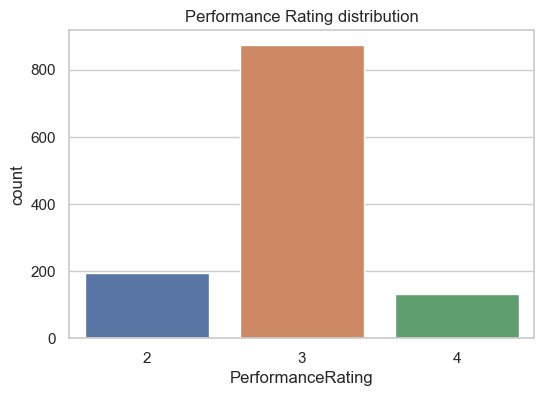

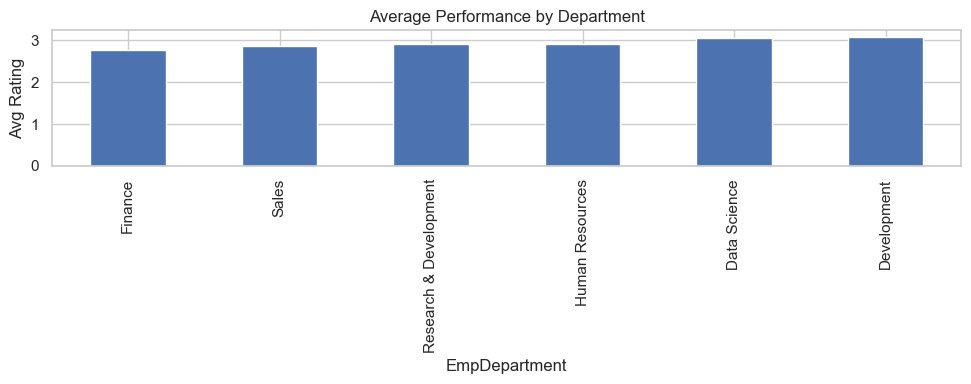

In [47]:
# === 5. Impute (robust) and basic EDA plots ===
# (Data had no missing values per earlier check; imputation kept for pipeline robustness)
X[num_features] = SimpleImputer(strategy='median').fit_transform(X[num_features])
X[cat_features] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_features])

# Distribution of target
plt.figure(figsize=(6,4)); sns.countplot(x=df[target]); plt.title('Performance Rating distribution'); plt.savefig(os.path.join(out_dir,'target_distribution.png')); plt.show()

# Department-wise average performance if a department column exists
dept_col = None
for c in df.columns:
    if 'department' in c.lower():
        dept_col = c; break
if dept_col:
    dept_mean = df.groupby(dept_col)[target].mean().sort_values()
    plt.figure(figsize=(10,4)); dept_mean.plot(kind='bar'); plt.title('Average Performance by Department'); plt.ylabel('Avg Rating'); plt.tight_layout(); plt.savefig(os.path.join(out_dir,'dept_avg_performance.png')); plt.show()
    dept_mean.to_csv(os.path.join(out_dir,'department_avg_performance.csv'))

In [48]:
# === 6. Feature association (mutual information + simple correlation on encoded values) ===
X_enc = X.copy()
for c in cat_features:
    X_enc[c] = LabelEncoder().fit_transform(X_enc[c].astype(str))
mi = mutual_info_classif(X_enc.fillna(0), y, discrete_features='auto', random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_enc.columns).sort_values(ascending=False)
print("Top mutual info features:")
display(mi_series.head(15))
mi_series.head(15).to_csv(os.path.join(out_dir,'mi_top15.csv'))

corr_with_target = X_enc.corrwith(pd.Series(y)).sort_values(key=lambda s: s.abs(), ascending=False)
display(corr_with_target.head(15))
corr_with_target.head(20).to_csv(os.path.join(out_dir,'corr_with_target_top20.csv'))

Top mutual info features:


EmpLastSalaryHikePercent        0.161783
EmpEnvironmentSatisfaction      0.154576
YearsSinceLastPromotion         0.090766
ExperienceYearsInCurrentRole    0.055622
EmpJobRole                      0.045150
ExperienceYearsAtThisCompany    0.037455
EmpHourlyRate                   0.033922
YearsWithCurrManager            0.030301
EmpDepartment                   0.024415
MaritalStatus                   0.020145
EmpJobSatisfaction              0.019102
Gender                          0.015226
OverTime                        0.011356
EmpEducationLevel               0.009183
EmpJobInvolvement               0.008164
dtype: float64

EmpEnvironmentSatisfaction      0.395561
EmpLastSalaryHikePercent        0.333722
YearsSinceLastPromotion        -0.167629
EmpDepartment                  -0.162615
ExperienceYearsInCurrentRole   -0.147638
EmpWorkLifeBalance              0.124429
YearsWithCurrManager           -0.122313
ExperienceYearsAtThisCompany   -0.111645
EmpJobRole                     -0.096209
EmpJobLevel                    -0.076632
TotalWorkExperienceInYears     -0.068141
OverTime                        0.050206
DistanceFromHome               -0.046142
EmpHourlyRate                  -0.043116
Age                            -0.040164
dtype: float64

In [49]:
# === 7. Preprocessing pipeline ===
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_features), ('cat', categorical_transformer, cat_features)])

In [50]:
# === 8. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print("Train/Test:", X_train.shape, X_test.shape)

Train/Test: (960, 26) (240, 26)



Training: LogisticRegression
LogisticRegression {'accuracy': 0.825, 'precision': 0.7709677419354839, 'recall': 0.6779975579975579, 'f1': 0.7157063129665869, 'roc_auc': 0.9093847321084034}
Classification report:
               precision    recall  f1-score   support

           2       0.61      0.49      0.54        39
           3       0.86      0.93      0.89       175
           4       0.84      0.62      0.71        26

    accuracy                           0.82       240
   macro avg       0.77      0.68      0.72       240
weighted avg       0.82      0.82      0.82       240



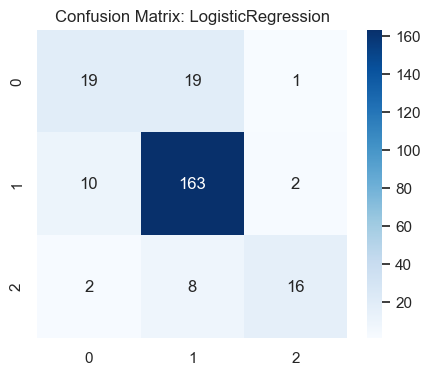


Training: RandomForest
RandomForest {'accuracy': 0.8916666666666667, 'precision': 0.9303807303807304, 'recall': 0.7378754578754579, 'f1': 0.7982140034771614, 'roc_auc': 0.9513237508553453}
Classification report:
               precision    recall  f1-score   support

           2       0.91      0.77      0.83        39
           3       0.88      0.98      0.93       175
           4       1.00      0.46      0.63        26

    accuracy                           0.89       240
   macro avg       0.93      0.74      0.80       240
weighted avg       0.90      0.89      0.88       240



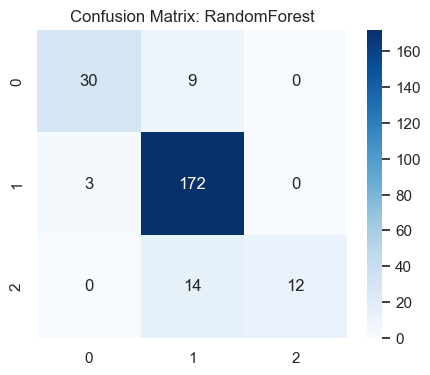


Training: GradientBoosting
GradientBoosting {'accuracy': 0.9291666666666667, 'precision': 0.9134031067732725, 'recall': 0.8622710622710623, 'f1': 0.8856035219133979, 'roc_auc': 0.9832728097783195}
Classification report:
               precision    recall  f1-score   support

           2       0.89      0.85      0.87        39
           3       0.94      0.97      0.96       175
           4       0.91      0.77      0.83        26

    accuracy                           0.93       240
   macro avg       0.91      0.86      0.89       240
weighted avg       0.93      0.93      0.93       240



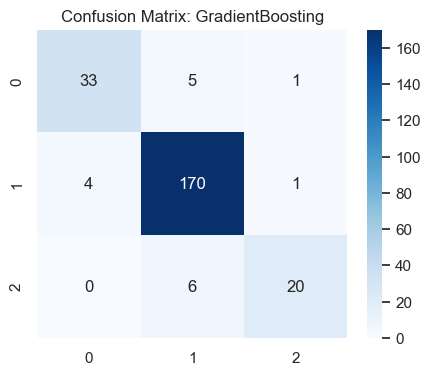

In [51]:
# === 9. Models to train ===
models = {
    'LogisticRegression': Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))]),
    'RandomForest': Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))]),
    'GradientBoosting': Pipeline([('pre', preprocessor), ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))])
}

results = {}
for name, pipe in models.items():
    print("\nTraining:", name)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    try:
        probs = pipe.predict_proba(X_test)
        if probs.shape[1] == 2:
            roc = roc_auc_score(y_test, probs[:,1])
        else:
            roc = roc_auc_score(y_test, probs, multi_class='ovr', average='macro')
    except Exception:
        roc = None
    results[name] = {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':roc}
    print(name, results[name])
    print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title(f'Confusion Matrix: {name}'); plt.savefig(os.path.join(out_dir,f'cm_{name}.png')); plt.show()

In [52]:
# === 10. Choose best model by macro F1 and save ===

# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
results_df = results_df[['Model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

# Round metrics for readability
results_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']] = results_df[
    ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
].applymap(lambda x: round(x, 4) if pd.notnull(x) else None)

# Identify the best model by F1
best_model_name = results_df.loc[results_df['f1'].idxmax(), 'Model']
best_row = results_df.loc[results_df['Model'] == best_model_name]

# Display results as a nice table
print(" Model Performance Comparison:")
display(results_df.style.highlight_max(subset=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], color='blue'))

# Print the best model
print(f" Best model by Macro F1: {best_model_name}")
display(best_row)

# Save the best model
joblib.dump(models[best_model_name], os.path.join(out_dir, f'best_model_{best_model_name}.pkl'))
print(f"Saved best model to: best_model_{best_model_name}.pkl")


 Model Performance Comparison:


,Model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.825000,0.771000,0.678000,0.715700,0.909400
1,RandomForest,0.891700,0.930400,0.737900,0.798200,0.951300
2,GradientBoosting,0.929200,0.913400,0.862300,0.885600,0.983300


 Best model by Macro F1: GradientBoosting


,Model,accuracy,precision,recall,f1,roc_auc
2,GradientBoosting,0.9292,0.9134,0.8623,0.8856,0.9833


Saved best model to: best_model_GradientBoosting.pkl


EmpLastSalaryHikePercent        0.164944
EmpEnvironmentSatisfaction      0.153163
YearsSinceLastPromotion         0.079968
EmpHourlyRate                   0.041224
ExperienceYearsInCurrentRole    0.037724
Age                             0.037130
ExperienceYearsAtThisCompany    0.032978
YearsWithCurrManager            0.032102
DistanceFromHome                0.031520
TotalWorkExperienceInYears      0.030287
NumCompaniesWorked              0.023280
TrainingTimesLastYear           0.021988
EmpWorkLifeBalance              0.021377
EmpDepartment_Development       0.021271
EmpJobSatisfaction              0.019236
EmpRelationshipSatisfaction     0.018634
EmpEducationLevel               0.018438
EmpJobRole_Developer            0.015913
EmpJobInvolvement               0.015461
EmpJobLevel                     0.014469
dtype: float64

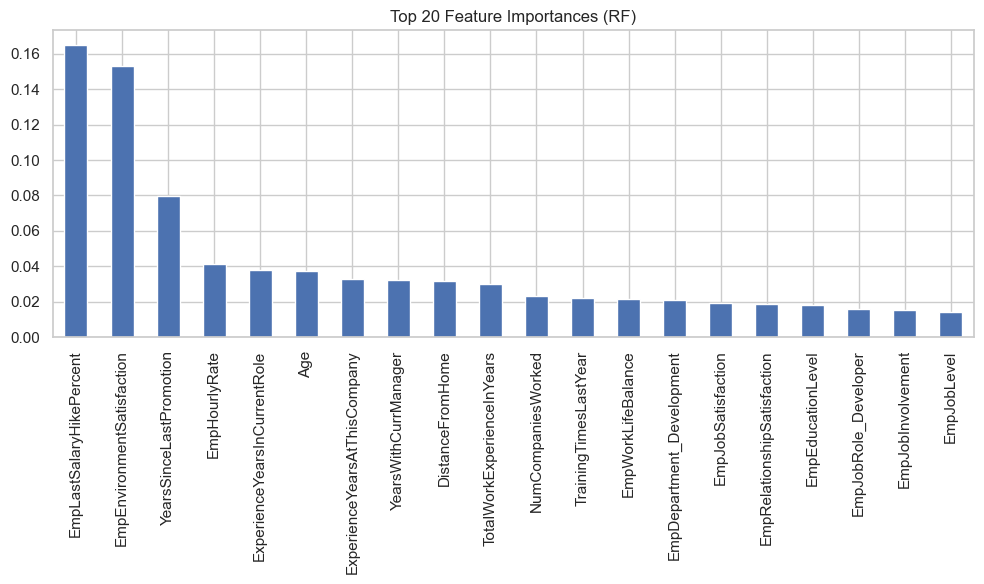

In [53]:
# === 11. Feature importance (Random Forest) ===
if 'RandomForest' in models:
    rf_pipe = models['RandomForest']
    # derive feature names: numeric + onehot categories
    feature_names = list(num_features)
    try:
        ohe = rf_pipe.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
        cat_names = list(ohe.get_feature_names_out(cat_features))
    except Exception:
        cat_names = []
        for c in cat_features:
            cats = sorted(df[c].astype(str).unique())
            cat_names += [f"{c}__{v}" for v in cats]
    feature_names += cat_names
    importances = rf_pipe.named_steps['clf'].feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
    display(feat_imp.head(20))
    feat_imp.to_csv(os.path.join(out_dir,'feature_importances.csv'))
    plt.figure(figsize=(10,6)); feat_imp.head(20).plot(kind='bar'); plt.title('Top 20 Feature Importances (RF)'); plt.tight_layout(); plt.savefig(os.path.join(out_dir,'feature_importances.png')); plt.show()


In [54]:
 #=== 12. Save predictions for test set ===
best_pipe = models[best_model_name]
y_pred_best = best_pipe.predict(X_test)
preds_df = X_test.reset_index(drop=True).copy()
preds_df['y_true'] = y_test
preds_df['y_pred'] = y_pred_best
preds_df.to_csv(os.path.join(out_dir,'test_set_predictions.csv'), index=False)


In [55]:
# === 13. Save summary metadata ===
summary = {
    'best_model': best_model_name,
    'metrics': results,
    'top_mi': mi_series.head(10).to_dict(),
    'corr_with_target_top10': corr_with_target.head(10).to_dict()
}
with open(os.path.join(out_dir,'project_summary.json'),'w') as f:
    json.dump(summary, f, indent=2)

print("\nDone. Outputs saved in folder:", out_dir)
print("Files:", os.listdir(out_dir))


Done. Outputs saved in folder: inx_outputs
Files: ['best_model_GradientBoosting.pkl', 'cm_GradientBoosting.png', 'cm_LogisticRegression.png', 'cm_RandomForest.png', 'corr_with_target_top20.csv', 'department_avg_performance.csv', 'dept_avg_performance.png', 'feature_importances.csv', 'feature_importances.png', 'mi_top15.csv', 'project_summary.json', 'target_distribution.png', 'test_set_predictions.csv']
